In [1]:
# libraries and functions
import sys
sys.path.append("../../functions")
from import_auxiliary import import_data
from save_load import save_data_a0, load_data_a0
from analysis import metrics_computation
from plot import metrics_plot, epi_curves

import numpy as np
from datetime import datetime
import os.path

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# path
path_CM_red = "../../data/compliant_matrix.json"
path_CM_yellow = "../../data/non_compliant_matrix.json"
path_Nij = "../../data/Nij.json"

# global variables
n_comp = 14                                                                                 # number of compartments
age_groups = ['0-4', '5-17', '18-29', '30-39', '40-49', '50-59', '60+']                     # list of strings with age groups 
age_groups_bins = [0, 5, 18, 30, 40, 50, 60, np.inf]                                        # list of int with age groups extremes 
n_age = len(age_groups)                                                                     # number of age groups
n_sev = 5                                                                                   # number of perceived severity groups

In [2]:
# IMPORT AND PARAMETERS

# import data
Italy_dict = import_data(path_CM_red, path_CM_yellow, path_Nij)  

# parameters

t_step = 1                                                                  # temporal step (in days)
initial_date = datetime(2020, 2, 1)                                         # starting date of the simulation
end_date = datetime(2021, 4, 1)                                             # ending date of the simulation
t_max = int((end_date - initial_date).days * (1/t_step))                    # number of days in the simulation
start_vaccination = initial_date                                            # starting date of vaccination
tV0 = int((start_vaccination - initial_date).days * (1/t_step))             # days after which the vaccination starts

beta = 0.08                                                                 # attack rate
mu = 1 / 5                                                                  # inverse of infectious period
delta = 15                                                                  # n. of days to death after the transition I -> R
chi = 0.55                                                                  # reduced infectiousness of presymptomatics and asymptomatics

type_v = 'age'                                                              # vaccination strategy
r_v = 0.0025                                                                # rate of vaccination
VE_S = 0.7                                                                  # vaccine efficacy on susceptibles
VE_Symp = 0.5                                                               # vaccine efficacy on symptoms
VE_D = 0.4                                                                  # vaccine efficacy on severe oucomes

i0 = 550000 / np.sum(Italy_dict["Nij"])                                     # initial conditions: fraction of individuals in infected compartments
icu0 = 2500 / np.sum(Italy_dict["Nij"])                                     # initial conditions: fraction of individuals in ICU
r0 = 0.1                                                                    # initial conditions: fraction of recovered individuals
d0 = 0                                                                      # initial conditions: fraction of deaths
ICU_max = 7200                                                              # max number of ICU

# age stratified parameters

f = [0.397, 0.573, 0.476, 0.407, 0.329, 0.265, 0.152]                       # Fraction of asymptomatics                   

IFR = [1.61e-05, 6.95e-05, 0.000309, 0.000844, 0.00161, 0.00595, 0.0328]    # Infectious Fatality Ratio for 7 age groups

PIH = [0.001, 0.001, 0.005, 0.011, 0.014, 0.029, 0.058]                     # Probabiity of being hospitalised if infected      
PHICU = [0.222, 0.222, 0.116, 0.159, 0.222, 0.276, 0.308]                   # Probabiity of going to ICU if hospitalised        
IICUR = [a*b for a,b in zip(PIH,PHICU)]                                     # Probabiity of going to ICU if infected

PICUD = [0.0, 0.0, 0.022, 0.048, 0.048, 0.116, 0.209]                       # Probabiity of dying if in ICU                     

function_types = ['lin', 'centerlin', 'startendlin', 'startlin', 'endlin']

comps = ['S', '$S_{NC}$', 'V', '$V_{NC}$', 'L', 'P', 'I', '$L_V$', '$P_V$', '$I_V$', 'A', 'ICU', 'R', 'D']

# Alpha variant: epsilon = 1/2.9, omega = 1/2.3

In [3]:
epsilon = 1 / 2.9                                                             # inverse of latent period                                      
omega = 1 / 2.3                                                               # inverse of presymptomatic period

## 3 metrics

In [4]:
# behavioral parameters
alpha = 10                                                                  # slope of C->NC transition
gamma = 5                                                                   # slope of NC->C transition
a0s = np.linspace(0.01, 1, num=30)                                          # array of midpoints of C->NC transition 
b0 = 0.75                                                                   # midpoint of NC->C transition
max_sigma = 0.3                                                             # maxium value of variance
grow = True                                                                 # True if variance refers to a0, False otherwise

# saving variables
folder = '../../runs/sensitivity_epidemiological/'
folder_fig = '../../output/sensitivity_epidemiological/'
string_save = f'Alphavariant_3metrics_heatmap_a0dict_gamma{gamma}_b0{b0}_alpha{alpha}.pickle'
string_fig = folder_fig + f'variant_sensitivity/3_metrics_varalpha.png'

In [5]:
# Generate data for the three metrics or load exisiting data
if os.path.exists(folder + string_save):
    a0_dict, sigma_a0_dict, cases_dict, deaths_dict, peak_high_dict, peak_date_dict = load_data_a0(folder + f'Alphavariant_', alpha, gamma, b0)
else:
    a0_dict, sigma_a0_dict, cases_dict, deaths_dict, peak_high_dict, peak_date_dict = metrics_computation(Italy_dict, i0, icu0, r0, d0, initial_date, t_max, tV0, beta, epsilon, omega, mu, delta, chi, f, IFR, IICUR, PICUD, ICU_max, r_v, type_v, VE_S, VE_Symp, VE_D, [alpha]*5, [gamma]*5, a0s, [b0]*5, t_step, max_sigma, grow, function_types)
    save_data_a0(folder, alpha, gamma, b0, a0_dict, sigma_a0_dict, cases_dict, deaths_dict, peak_high_dict, peak_date_dict)

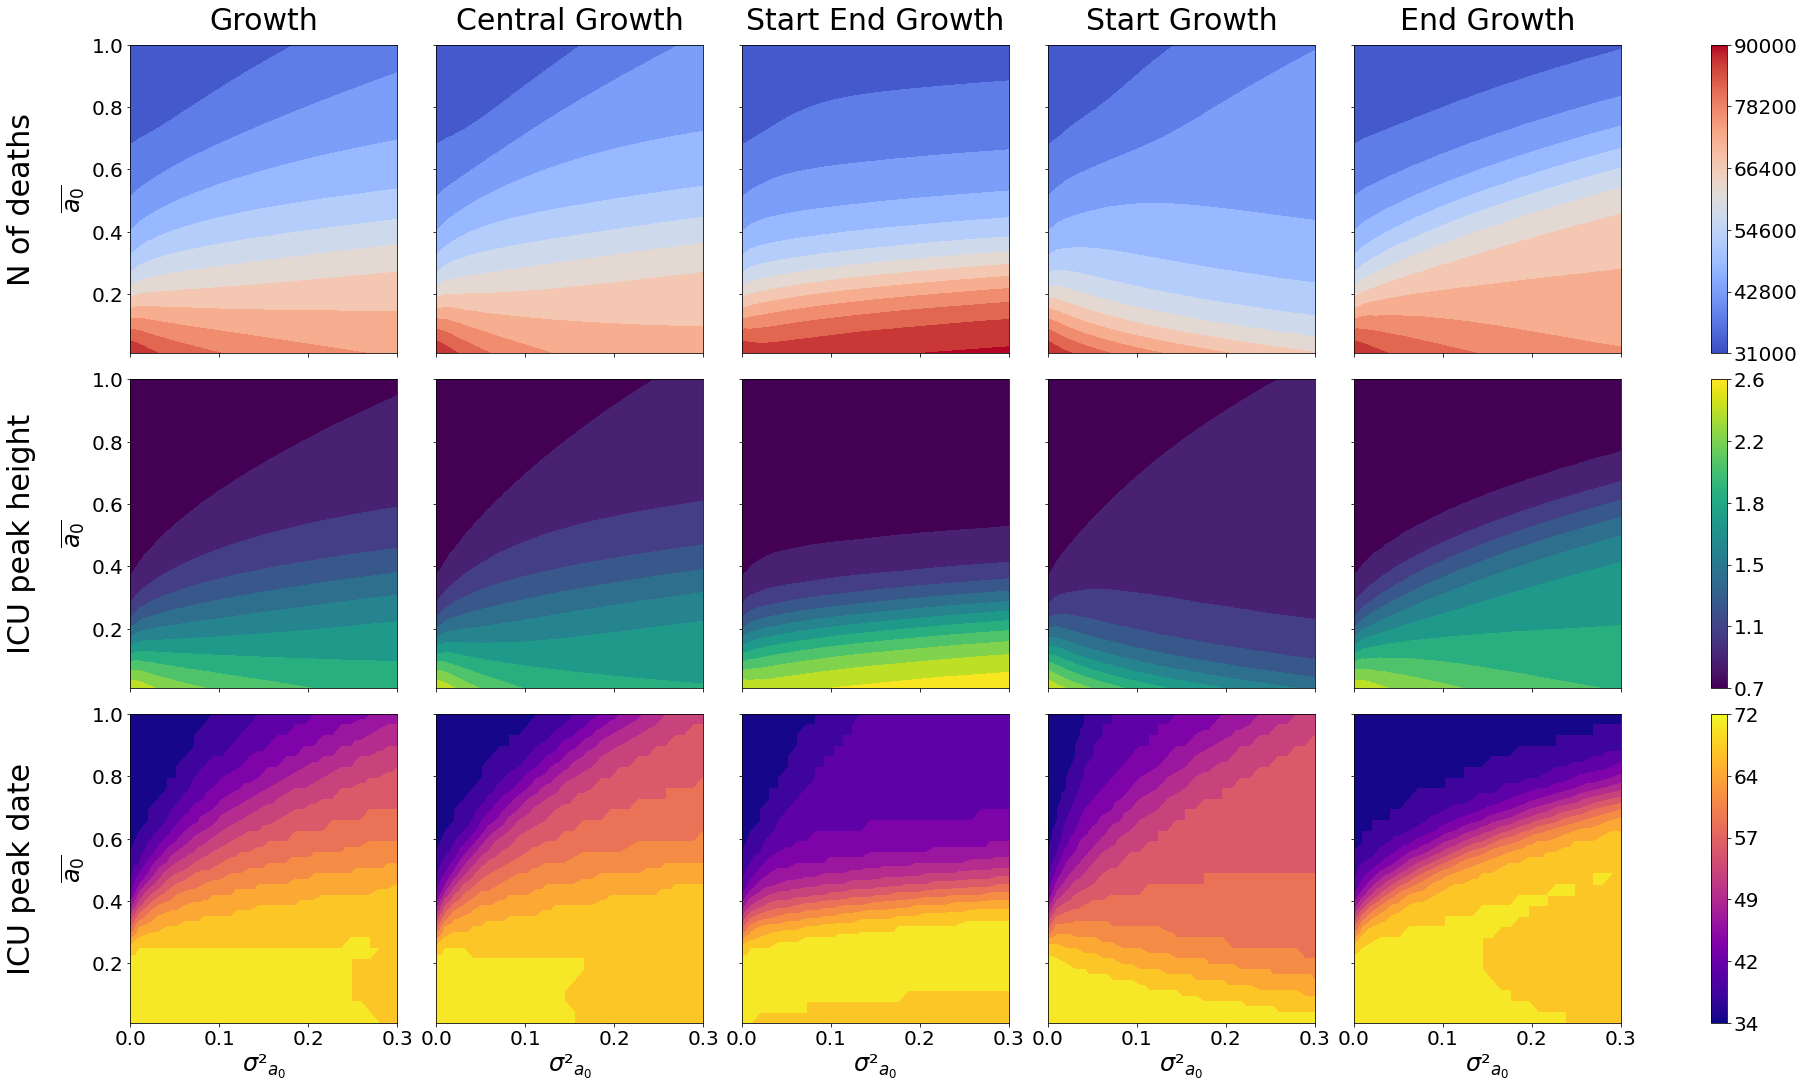

In [6]:
# Plot the three metrics for each of the five functions
metrics_plot(a0_dict, sigma_a0_dict, deaths_dict, peak_high_dict, peak_date_dict, grow, function_types, savefig = string_fig)

## Epidemiological curves

In [7]:
a0 = 0.6                                                                    # midpoint of C->NC transition
fun_type = 'lin'                                                            # function used
string_fig = folder_fig + f'variant_sensitivity/Epicurves_varalpha.png'

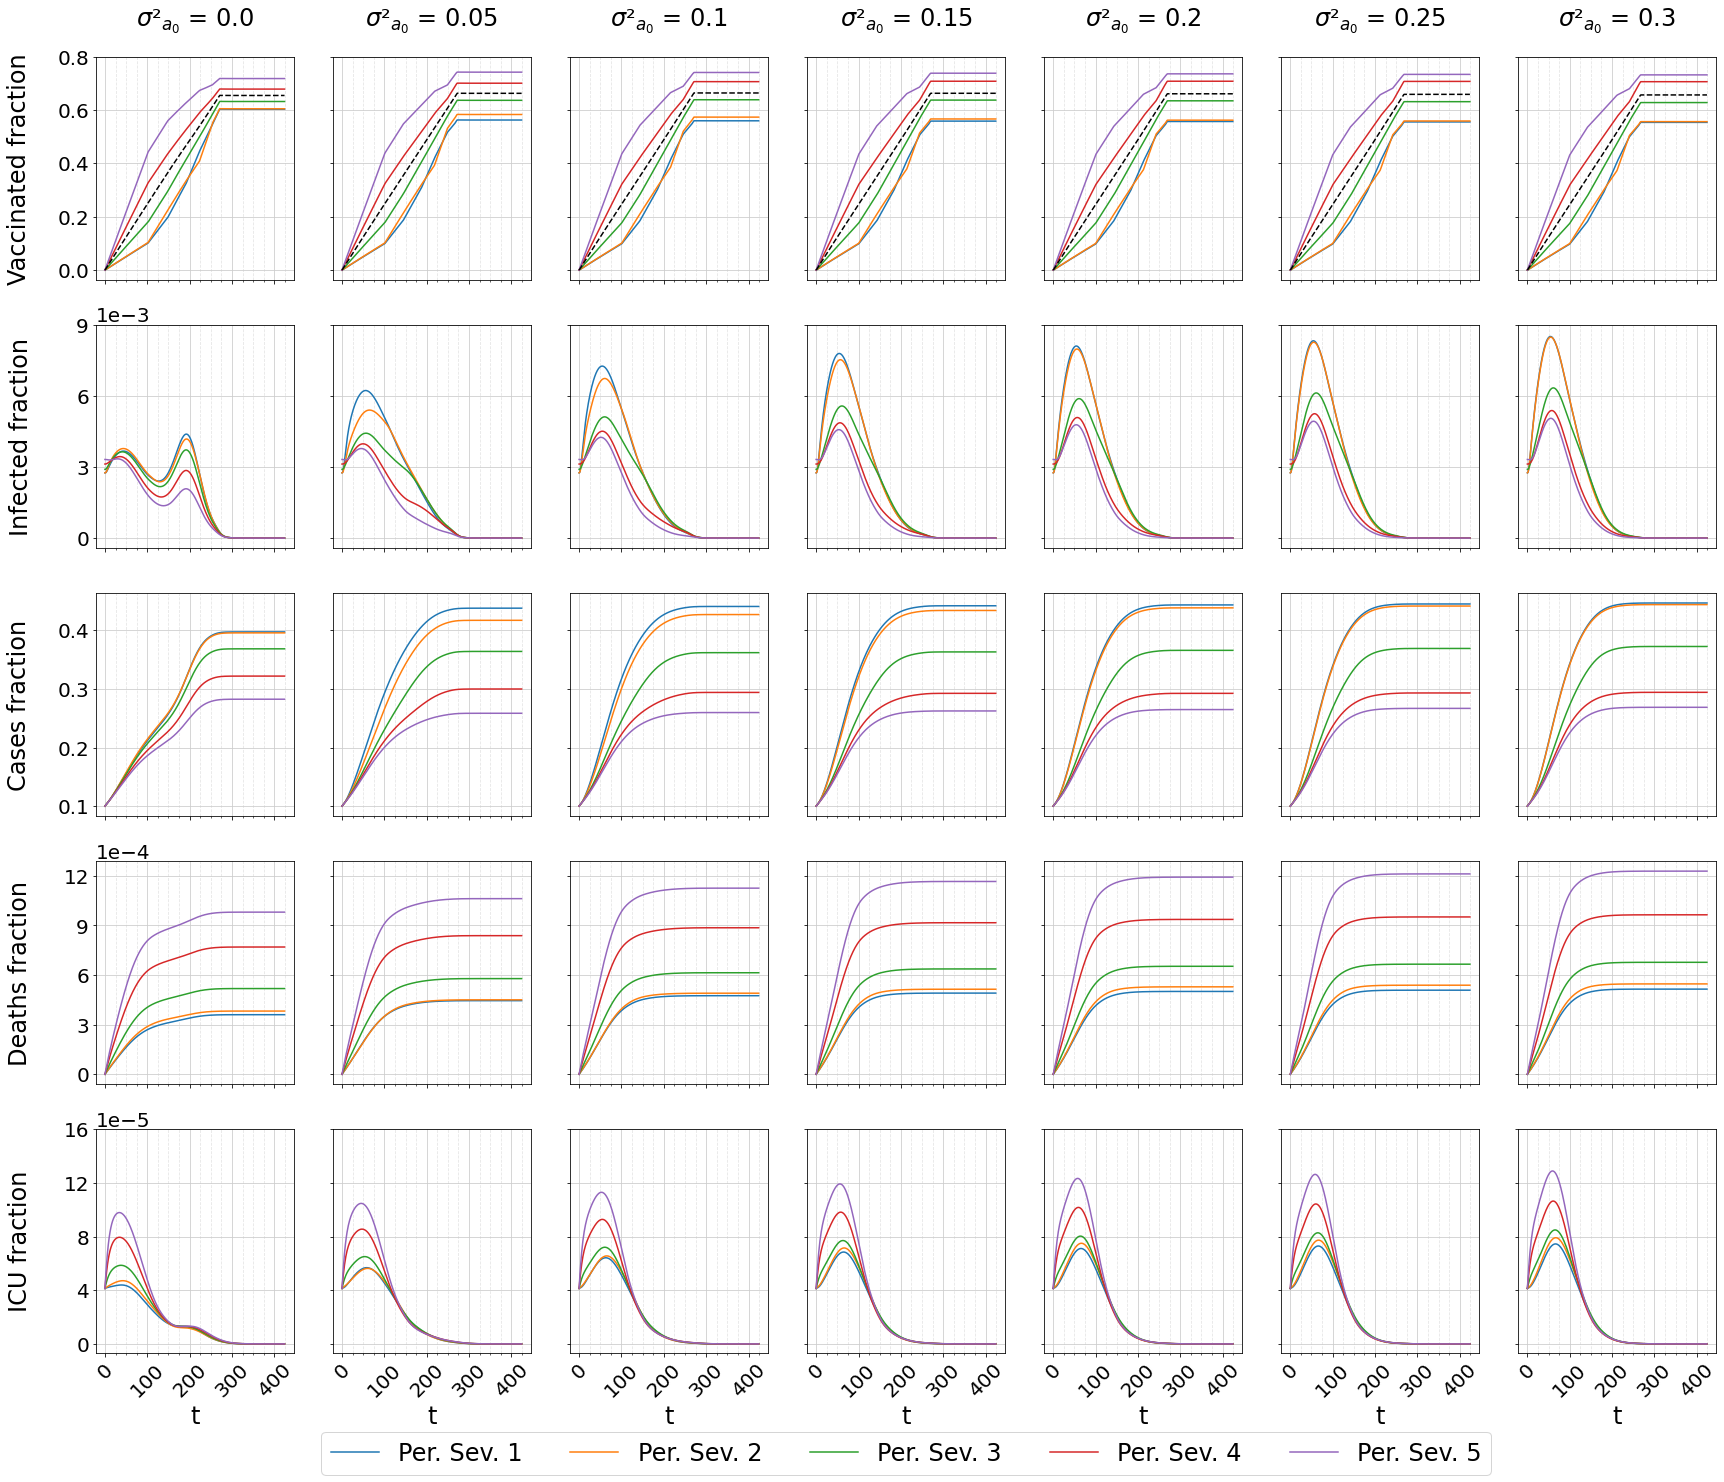

In [8]:
# Plot fraction of vaccinated, infected individuals, cases, deaths, and ICU for several values of variance
epi_curves(Italy_dict, i0, icu0, r0, d0, initial_date, t_max, tV0, beta, epsilon, omega, mu, delta, chi, f, IFR, IICUR, PICUD, ICU_max, r_v, type_v, VE_S, VE_Symp, VE_D, alpha, gamma, a0, b0, t_step, max_sigma, grow, fun_type, savefig = string_fig)